In [1]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import (
    EulerSolver,
    plot_1d_slice,
)
from superfv.initial_conditions import decaying_isotropic_turbulence

In [2]:
seed = 1
N = 100
T = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

configs = {
    "p0": dict(riemann_solver="hllc", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        flux_recipe=2,
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        adaptive_lazy=True,
        ZS=True,
        PAD={"rho": (0, None)},
    ),
    # "MM3": dict(
    #     riemann_solver="hllc",
    #     p=3,
    #     flux_recipe=2,
    #     lazy_primitives=True,
    #     MOOD=True,
    #     limiting_vars=("rho", "vx"),
    #     cascade="muscl",
    #     MUSCL_limiter="moncen",
    #     max_MOOD_iters=1,
    #     NAD=True,
    #     NAD_rtol=1e-2,
    #     NAD_atol=1e-8,
    #     PAD={"rho": (0, None)},
    # ),
}

In [3]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(
            decaying_isotropic_turbulence,
            seed=seed,
            M=10,
            slope=-5 / 3,
            solenoidal=False,
        ),
        isothermal=True,
        nx=N,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True)
        else:
            sim.run(T, q_max=2, allow_overshoot=True)
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #359 @ t=8.00e-01 | dt=4.33e-03 | min(rho)=7.31e-01, min(P)=7.31e-01 | (ran in 0.15s)          
Running simulation: MUSCL-Hancock
Step #478 @ t=8.01e-01 | dt=2.86e-03 | min(rho)=2.68e-01, min(P)=2.68e-01 | (ran in 0.25s)          
Running simulation: ZS3
Step #375 @ t=8.02e-01 | dt=4.42e-03 | min(rho)=6.96e-01, min(P)=6.96e-01 | (ran in 1.76s)          


/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.101424
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.101424
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100873
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100873
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100159
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; usi

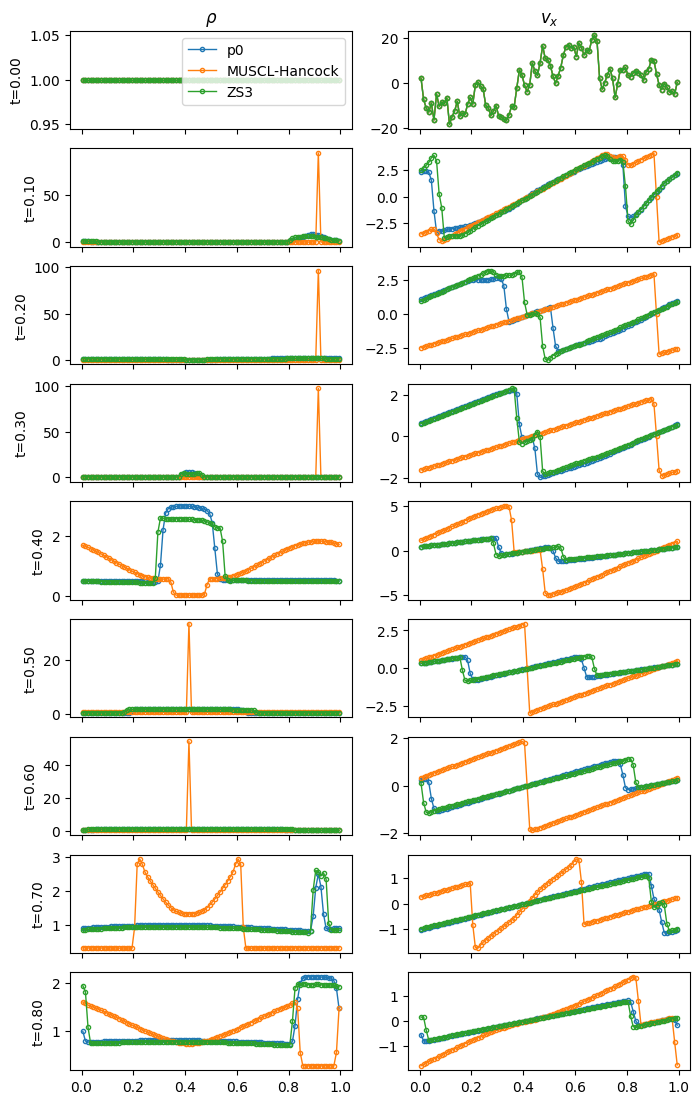

In [4]:
fig, axs = plt.subplots(len(T) + 1, 2, figsize=(8, 12 * (len(T) + 1) / 8), sharex=True)

axs[0, 0].set_title(r"$\rho$")
axs[0, 1].set_title(r"$v_x$")

style0 = dict(color="k", linestyle="--", linewidth=1)
style1 = dict(linewidth=1, markersize=3, marker="o", mfc="none")

for i, tplot in enumerate([0] + T):
    for name, sim in sims.items():
        axs[i, 0].set_ylabel(f"t={tplot:.2f}")
        plot_1d_slice(sim, axs[i, 0], "rho", t=tplot, label=name, **style1)
        plot_1d_slice(sim, axs[i, 1], "vx", t=tplot, label=name, **style1)
axs[0, 0].legend()